# `EmissionAbsorptionModel` Tutorial

Trey V. Wenger (c) November 2024

Here we demonstrate the `EmissionAbsorptionModel` model. `EmissionAbsorptionModel` is a more physically motivated model than `AbsorptionModel`, and it also predicts the brightness temperature spectra for the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH. This notebook is otherwise identical to the `AbsorptionModel` notebook.

In [1]:
# General imports    
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pytensor
print("pytensor version:", pytensor.__version__)

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.26.3
pymc version: 5.18.2
bayes_spec version: 1.7.2
amoeba2 version: 1.0.1+7.gad490bf.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the absorption ($1-\exp(-\tau)$) observations to be named `"absorption_1612", "absorption_1665", "absorption_1667", and "absorption_1720"` and the brightnes temperature observations to be named `"emission_1612", "emission_1665", "emission_1667", and "emission_1720"`.

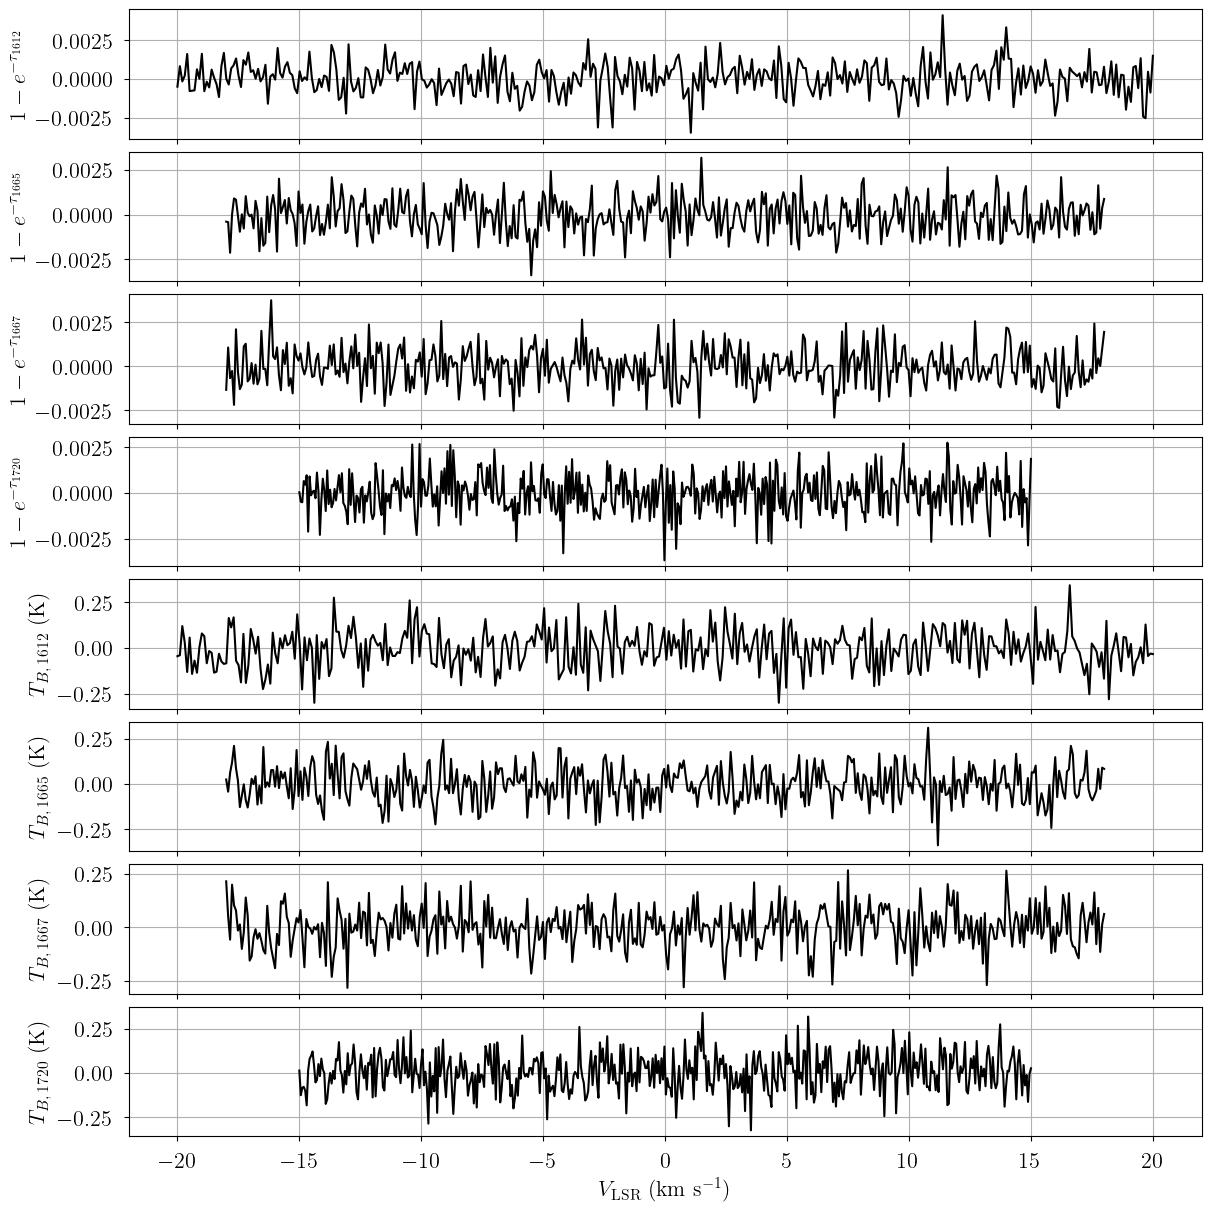

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_absorption = {
    "1612": 0.001,
    "1665": 0.001,
    "1667": 0.001,
    "1720": 0.001,
}
rms_emission = {
    "1612": 0.1,
    "1665": 0.1,
    "1667": 0.1,
    "1720": 0.1,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = {label: rms_absorption[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}
emission = {label: rms_emission[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"absorption_{label}": SpecData(
        velo_axis[label],
        absorption[label],
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}
for label in velo_axis.keys():
    dummy_data[f"emission_{label}"] = SpecData(
        velo_axis[label],
        emission[label],
        rms_emission[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$ (K)"
    )

# Plot dummy data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from amoeba2 import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 1.0], # mean and width of log10(N0) prior (cm-2)
    prior_log_boltz_factor = [-0.1, 1.0], # mean and width of log(Boltzmann factor) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log_boltz_factor_1612": np.array([-0.05, 0.1, 0.05]),
    "log_boltz_factor_1665": np.array([-0.1, -0.05, -0.02]),
    "log_boltz_factor_1667": np.array([-0.05, -0.02, -0.1]),
    "log10_N0": np.array([13.0, 13.5, 12.5]),
    "log10_depth": np.array([0.0, 0.25, -0.25]),
    "log10_Tkin": np.array([1.25, 1.75, 1.0]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "log10_nth_fwhm_1pc": 0.2,
    "depth_nth_fwhm_power": 0.3,
    "baseline_absorption_1612_norm": [0.0],
    "baseline_absorption_1665_norm": [0.0],
    "baseline_absorption_1667_norm": [0.0],
    "baseline_absorption_1720_norm": [0.0],
    "baseline_emission_1612_norm": [0.0],
    "baseline_emission_1665_norm": [0.0],
    "baseline_emission_1667_norm": [0.0],
    "baseline_emission_1720_norm": [0.0],
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    # Simulate optical depth
    absorption = model.model[f"absorption_{label}"].eval(sim_params, on_unused_input="ignore")
    data[f"absorption_{label}"] = SpecData(
        velo_axis[label],
        absorption,
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )
    
    # Simulate brightness temperature
    emission = model.model[f"emission_{label}"].eval(sim_params, on_unused_input="ignore")
    data[f"emission_{label}"] = SpecData(
        velo_axis[label],
        emission,
        rms_emission[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_{B,\,"+f"{label}"+r"}$"
    )

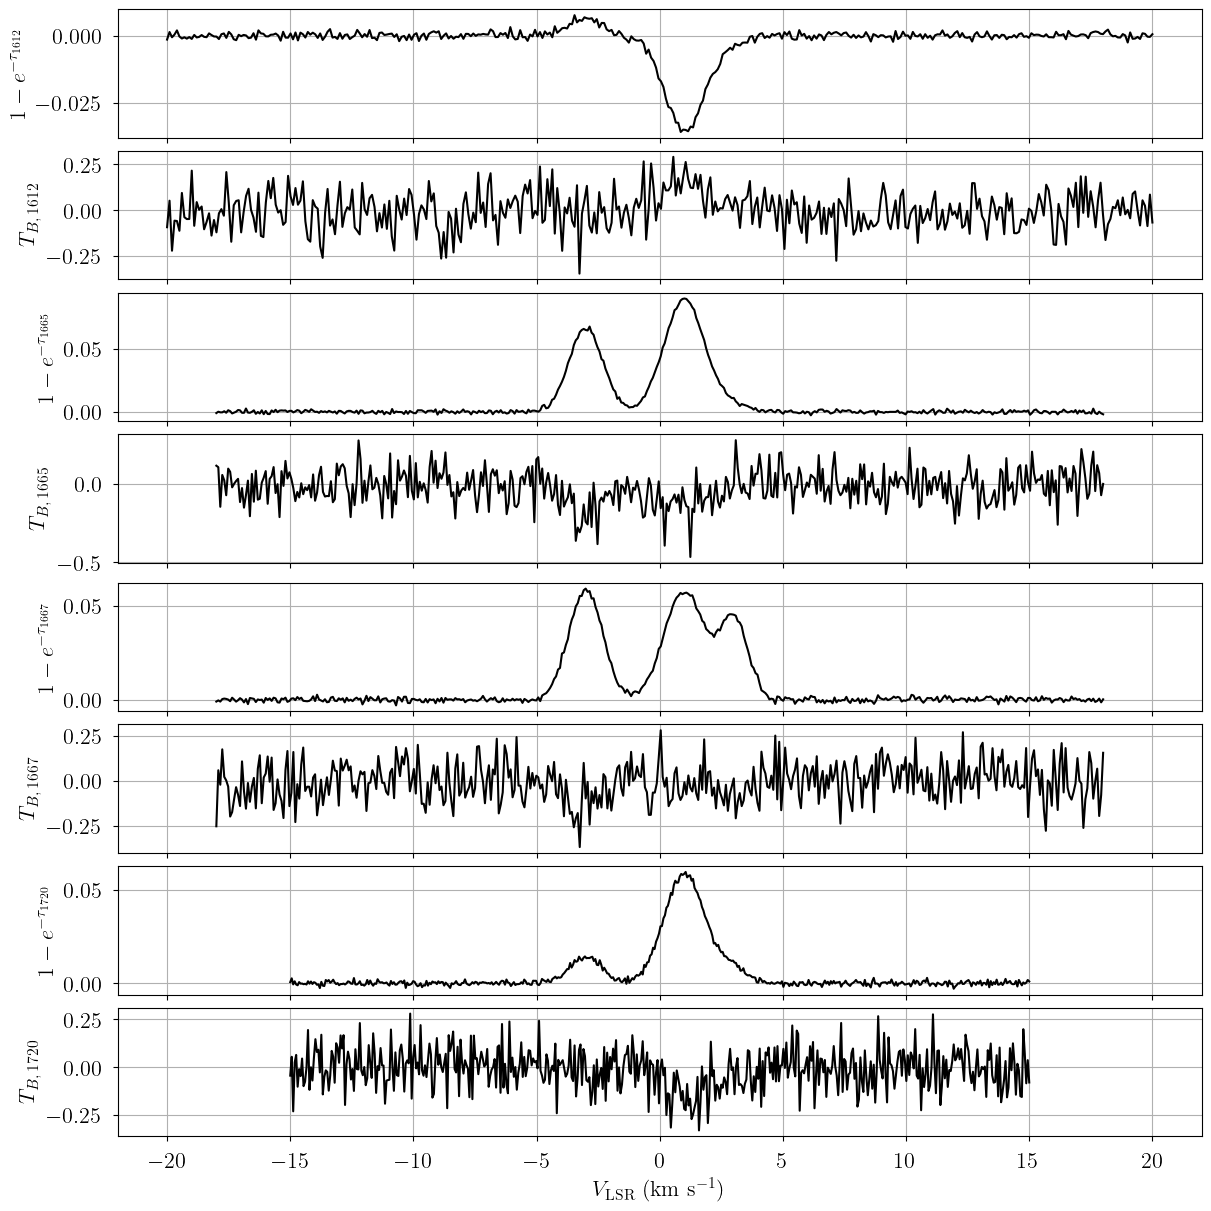

In [5]:
# Plot data
fig, axes = plt.subplots(8, sharex=True, layout="constrained", figsize=(12, 12))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

In [6]:
# Initialize and define the model
model = EmissionAbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 1.0], # mean and width of log10(N0) prior (cm-2)
    prior_log_boltz_factor = [-0.1, 1.0], # mean and width of log(Boltzmann factor) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    ordered = False, # do not assume optically-thin
    mainline_pos_tau = True, # force main line optical depths to be positive
)
model.add_likelihood()

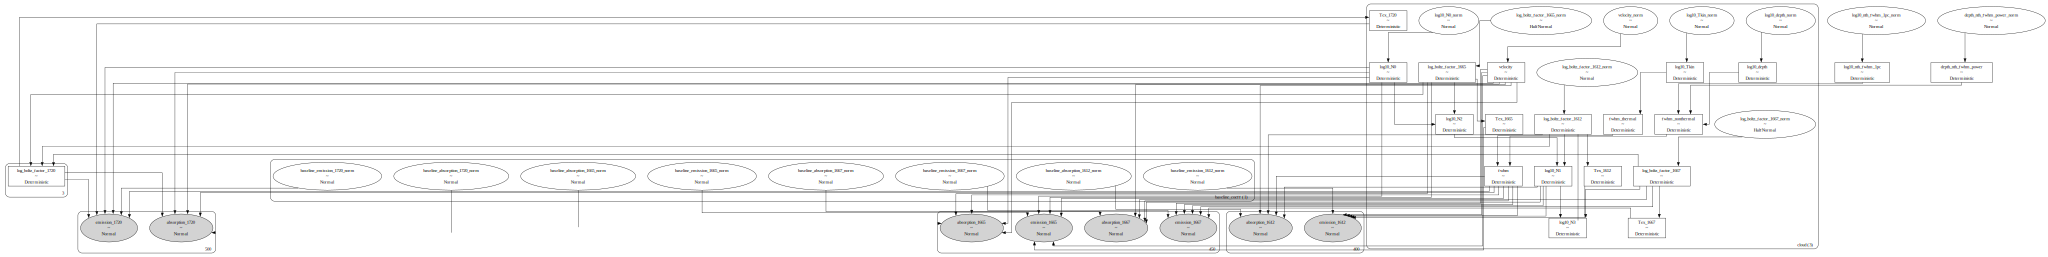

In [8]:
# Plot model graph
import pymc as pm
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.5"
gviz.render('emission_absorption_model', format='png')
gviz

In [9]:
# model string representation
print(model.model.str_repr())

baseline_absorption_1612_norm ~ Normal(0, 1)
  baseline_emission_1612_norm ~ Normal(0, 1)
baseline_absorption_1665_norm ~ Normal(0, 1)
  baseline_emission_1665_norm ~ Normal(0, 1)
baseline_absorption_1667_norm ~ Normal(0, 1)
  baseline_emission_1667_norm ~ Normal(0, 1)
baseline_absorption_1720_norm ~ Normal(0, 1)
  baseline_emission_1720_norm ~ Normal(0, 1)
                log10_N0_norm ~ Normal(0, 1)
   log_boltz_factor_1612_norm ~ Normal(0, 1)
   log_boltz_factor_1665_norm ~ HalfNormal(0, 1)
   log_boltz_factor_1667_norm ~ HalfNormal(0, 1)
             log10_depth_norm ~ Normal(0, 1)
              log10_Tkin_norm ~ Normal(0, 1)
                velocity_norm ~ Normal(0, 1)
      log10_nth_fwhm_1pc_norm ~ Normal(0, 1)
    depth_nth_fwhm_power_norm ~ Normal(0, 1)
                     log10_N0 ~ Deterministic(f(log10_N0_norm))
        log_boltz_factor_1612 ~ Deterministic(f(log_boltz_factor_1612_norm))
        log_boltz_factor_1665 ~ Deterministic(f(log_boltz_factor_1665_norm))
        l

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720, baseline_absorption_1612_norm, baseline_absorption_1665_norm, baseline_absorption_1667_norm, baseline_absorption_1720_norm, baseline_emission_1612_norm, baseline_emission_1665_norm, baseline_emission_1667_norm, baseline_emission_1720_norm, depth_nth_fwhm_power_norm, emission_1612, emission_1665, emission_1667, emission_1720, log10_N0_norm, log10_Tkin_norm, log10_depth_norm, log10_nth_fwhm_1pc_norm, log_boltz_factor_1612_norm, log_boltz_factor_1665_norm, log_boltz_factor_1667_norm, velocity_norm]


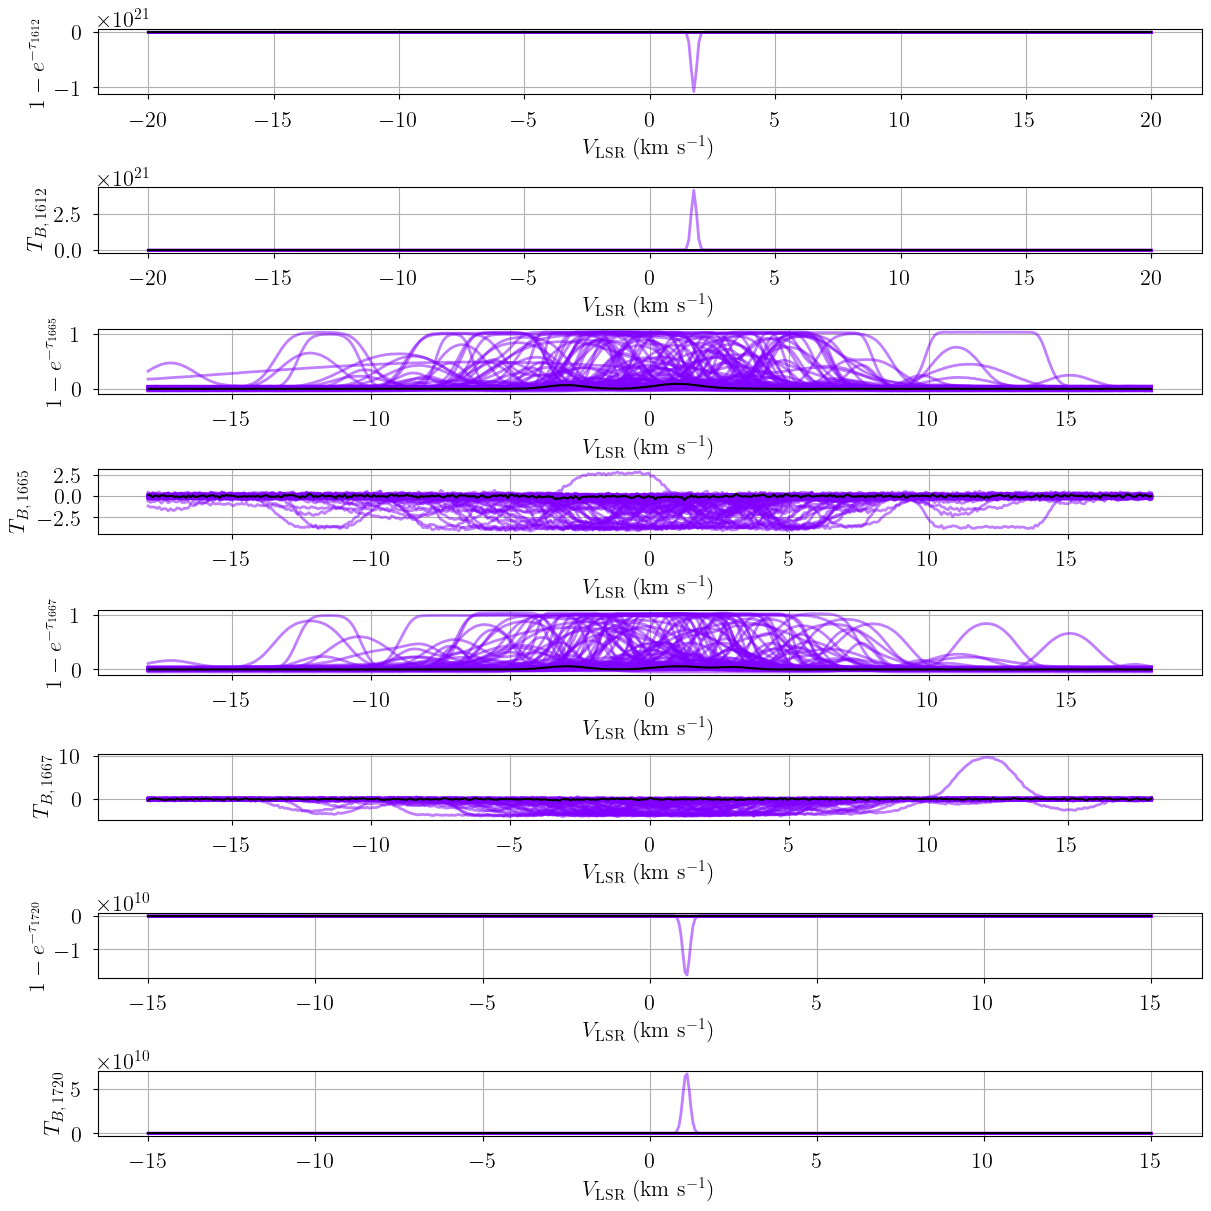

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [12]:
import time

start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 5.7397e+05


Output()

Runtime: 2.59 minutes


In [13]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_absorption_1612_norm[0]   0.243  0.008   0.227    0.257      0.000   
baseline_emission_1612_norm[0]    -0.067  0.052  -0.160    0.034      0.002   
baseline_absorption_1665_norm[0]  -0.417  0.003  -0.422   -0.413      0.000   
baseline_emission_1665_norm[0]     0.276  0.044   0.194    0.360      0.001   
baseline_absorption_1667_norm[0]  -0.477  0.003  -0.483   -0.471      0.000   
baseline_emission_1667_norm[0]     0.261  0.047   0.175    0.350      0.002   
baseline_absorption_1720_norm[0]  -0.424  0.004  -0.433   -0.418      0.000   
baseline_emission_1720_norm[0]     0.186  0.046   0.101    0.270      0.001   
log10_N0_norm[0]                  -0.842  0.002  -0.845   -0.838      0.000   
log10_N0_norm[1]                  -0.274  0.001  -0.276   -0.272      0.000   
log10_N0_norm[2]                  -1.243  0.004  -1.250   -1.236      0.000   
log_boltz_factor_1612_norm[0]     -0.561  0.006  -0.571   -0.551      0.000   
log_boltz_factor_1612_norm[1]      1.531  0.005   1.521    1.540      0.000   
log_boltz_factor_1612_norm[2]      0.411  0.008   0.396    0.426      0.000   
log10_depth_norm[0]               -0.243  0.025  -0.291   -0.199      0.001   
log10_depth_norm[1]                0.691  0.020   0.652    0.726      0.001   
log10_depth_norm[2]               -1.337  0.053  -1.442   -1.240      0.002   
log10_Tkin_norm[0]                -1.067  0.359  -1.745   -0.436      0.011   
log10_Tkin_norm[1]                 0.008  0.054  -0.097    0.107      0.002   
log10_Tkin_norm[2]                -1.178  0.470  -2.105   -0.342      0.015   
velocity_norm[0]                  -0.600  0.001  -0.601   -0.598      0.000   
velocity_norm[1]                   0.199  0.001   0.198    0.201      0.000   
velocity_norm[2]                   0.602  0.001   0.600    0.605      0.000   
log10_nth_fwhm_1pc_norm            0.194  0.011   0.173    0.214      0.000   
depth_nth_fwhm_power_norm         -1.034  0.071  -1.170   -0.901      0.002   
log_boltz_factor_1665_norm[0]      1.085  0.005   1.076    1.093      0.000   
log_boltz_factor_1665_norm[1]      0.341  0.001   0.339    0.343      0.000   
log_boltz_factor_1665_norm[2]      0.112  0.005   0.102    0.123      0.000   
log_boltz_factor_1667_norm[0]      0.683  0.005   0.673    0.693      0.000   
log_boltz_factor_1667_norm[1]      0.914  0.008   0.899    0.930      0.000   
log_boltz_factor_1667_norm[2]      1.372  0.023   1.328    1.412      0.001   
log10_N0[0]                       12.158  0.002  12.155   12.162      0.000   
log10_N0[1]                       12.726  0.001  12.724   12.728      0.000   
log10_N0[2]                       11.757  0.004  11.750   11.764      0.000   
log_boltz_factor_1612[0]          -0.661  0.006  -0.671   -0.651      0.000   
log_boltz_factor_1612[1]           1.431  0.005   1.421    1.440      0.000   
log_boltz_factor_1612[2]           0.311  0.008   0.296    0.326      0.000   
log_boltz_factor_1665[0]          -1.085  0.005  -1.093   -1.076      0.000   
log_boltz_factor_1665[1]          -0.341  0.001  -0.343   -0.339      0.000   
log_boltz_factor_1665[2]          -0.112  0.005  -0.123   -0.102      0.000   
log_boltz_factor_1667[0]          -0.683  0.005  -0.693   -0.673      0.000   
log_boltz_factor_1667[1]          -0.914  0.008  -0.930   -0.899      0.000   
log_boltz_factor_1667[2]          -1.372  0.023  -1.412   -1.328      0.001   
log_boltz_factor_1720[0]          -1.106  0.009  -1.124   -1.090      0.000   
log_boltz_factor_1720[1]          -2.686  0.010  -2.702   -2.666      0.000   
log_boltz_factor_1720[2]          -1.795  0.025  -1.840   -1.749      0.001   
log10_N2[0]                       11.687  0.003  11.682   11.692      0.000   
log10_N2[1]                       12.578  0.001  12.575   12.580      0.000   
log10_N2[2]                       11.709  0.004  11.701   11.717      0.000   
log10_N1[0]                       12.196  0.004  12.189   12.203      0.000   
log10_N

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720, emission_1612, emission_1665, emission_1667, emission_1720]


Output()

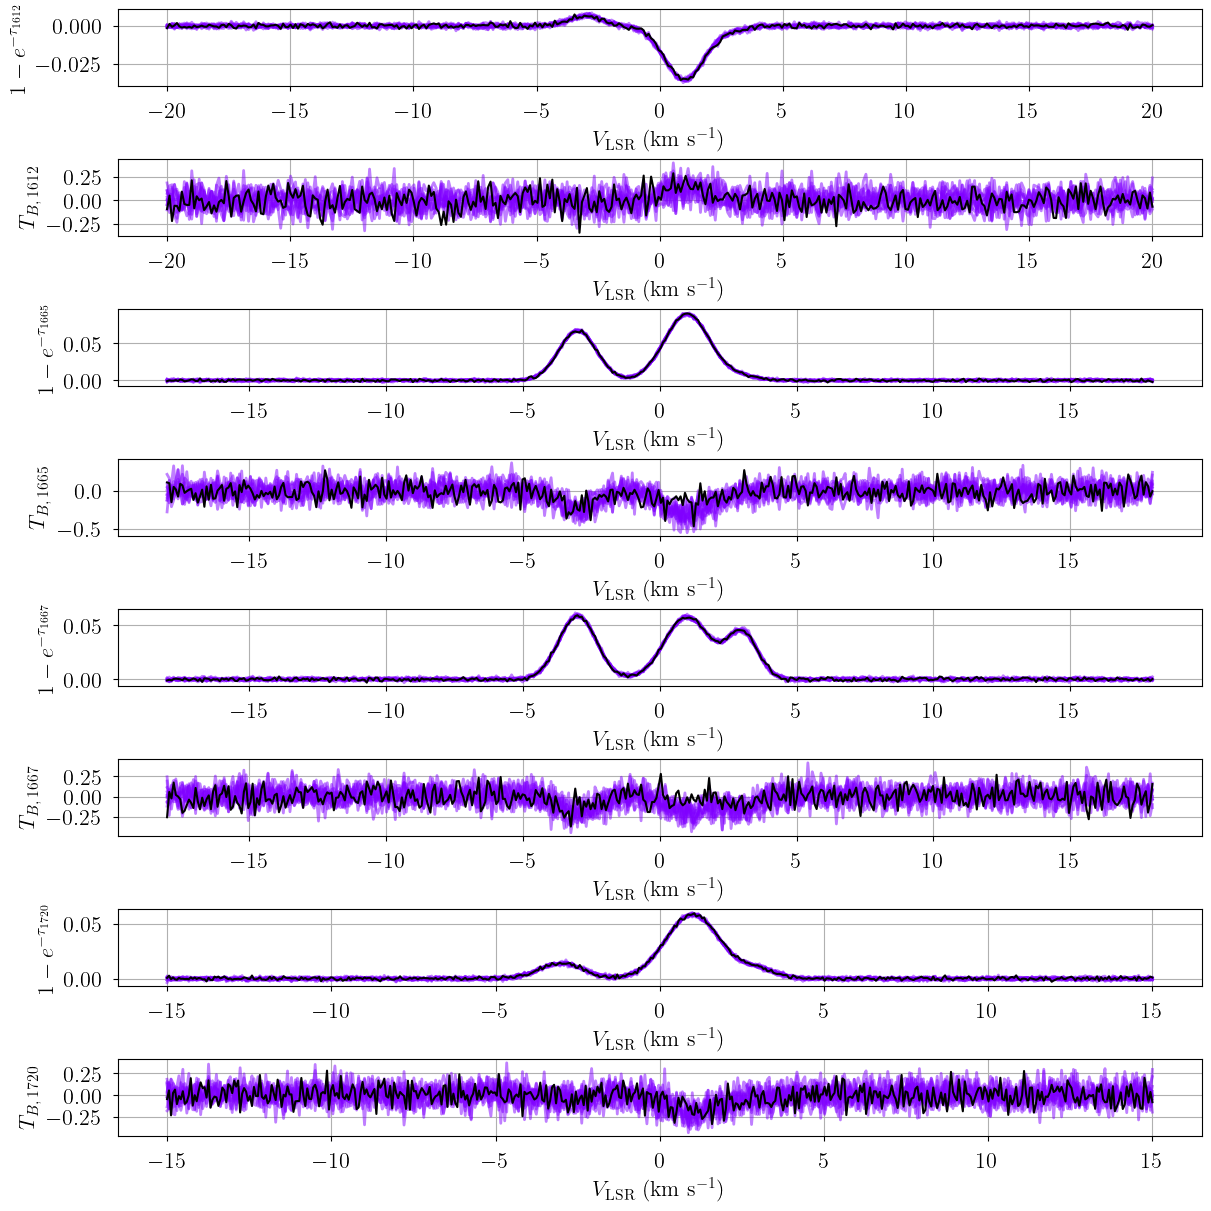

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Posterior Sampling: MCMC


In [15]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 5.7397e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_1612_norm, baseline_emission_1612_norm, baseline_absorption_1665_norm, baseline_emission_1665_norm, baseline_absorption_1667_norm, baseline_emission_1667_norm, baseline_absorption_1720_norm, baseline_emission_1720_norm, log10_N0_norm, log_boltz_factor_1612_norm, log_boltz_factor_1665_norm, log_boltz_factor_1667_norm, log10_depth_norm, log10_Tkin_norm, velocity_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3454 seconds.


Adding log-likelihood to trace


Output()

There were 64 divergences in converged chains.
Runtime: 59.61 minutes


In [16]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [17]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_absorption_1612_norm[0]   0.239  0.008   0.225    0.254      0.000   
baseline_emission_1612_norm[0]    -0.073  0.049  -0.166    0.015      0.001   
baseline_absorption_1665_norm[0]  -0.420  0.003  -0.425   -0.415      0.000   
baseline_emission_1665_norm[0]     0.220  0.044   0.140    0.308      0.001   
baseline_absorption_1667_norm[0]  -0.478  0.003  -0.484   -0.472      0.000   
baseline_emission_1667_norm[0]     0.154  0.047   0.064    0.240      0.001   
baseline_absorption_1720_norm[0]  -0.415  0.004  -0.422   -0.407      0.000   
baseline_emission_1720_norm[0]     0.168  0.042   0.090    0.249      0.001   
log10_N0_norm[0]                  -0.685  0.229  -0.969   -0.233      0.007   
log10_N0_norm[1]                   0.458  0.039   0.385    0.531      0.001   
log10_N0_norm[2]                  -1.105  0.195  -1.324   -0.708      0.007   
log_boltz_factor_1612_norm[0]     -0.413  0.352  -1.055    0.054      0.011   
log_boltz_factor_1612_norm[1]      0.213  0.012   0.193    0.235      0.000   
log_boltz_factor_1612_norm[2]      0.337  0.092   0.157    0.478      0.003   
log10_depth_norm[0]               -0.025  0.663  -1.237    1.285      0.015   
log10_depth_norm[1]                0.541  0.767  -1.040    1.894      0.017   
log10_depth_norm[2]               -0.784  0.632  -1.990    0.378      0.012   
log10_Tkin_norm[0]                -0.233  0.790  -1.611    1.018      0.013   
log10_Tkin_norm[1]                 0.118  0.855  -1.406    1.247      0.017   
log10_Tkin_norm[2]                -0.463  0.716  -1.839    0.681      0.011   
velocity_norm[0]                  -0.600  0.001  -0.601   -0.599      0.000   
velocity_norm[1]                   0.201  0.001   0.200    0.202      0.000   
velocity_norm[2]                   0.603  0.001   0.600    0.605      0.000   
log10_nth_fwhm_1pc_norm           -0.266  0.550  -1.373    0.701      0.012   
depth_nth_fwhm_power_norm         -0.120  0.929  -1.987    1.475      0.014   
log_boltz_factor_1665_norm[0]      0.843  0.504   0.096    1.720      0.016   
log_boltz_factor_1665_norm[1]      0.056  0.005   0.046    0.065      0.000   
log_boltz_factor_1665_norm[2]      0.087  0.030   0.027    0.133      0.001   
log_boltz_factor_1667_norm[0]      0.533  0.370   0.047    1.211      0.012   
log_boltz_factor_1667_norm[1]      0.023  0.003   0.018    0.028      0.000   
log_boltz_factor_1667_norm[2]      0.965  0.620   0.047    2.014      0.017   
log10_N0[0]                       12.315  0.229  12.031   12.767      0.007   
log10_N0[1]                       13.458  0.039  13.385   13.531      0.001   
log10_N0[2]                       11.895  0.195  11.676   12.292      0.007   
log_boltz_factor_1612[0]          -0.513  0.352  -1.155   -0.046      0.011   
log_boltz_factor_1612[1]           0.113  0.012   0.093    0.135      0.000   
log_boltz_factor_1612[2]           0.237  0.092   0.057    0.378      0.003   
log_boltz_factor_1665[0]          -0.843  0.504  -1.720   -0.096      0.016   
log_boltz_factor_1665[1]          -0.056  0.005  -0.065   -0.046      0.000   
log_boltz_factor_1665[2]          -0.087  0.030  -0.133   -0.027      0.001   
log_boltz_factor_1667[0]          -0.533  0.370  -1.211   -0.047      0.012   
log_boltz_factor_1667[1]          -0.023  0.003  -0.028   -0.018      0.000   
log_boltz_factor_1667[2]          -0.965  0.620  -2.014   -0.047      0.017   
log_boltz_factor_1720[0]          -0.862  0.523  -1.777   -0.095      0.016   
log_boltz_factor_1720[1]          -0.192  0.020  -0.228   -0.157      0.001   
log_boltz_factor_1720[2]          -1.289  0.732  -2.513   -0.103      0.020   
log10_N2[0]                       11.949  0.436  11.229   12.770      0.014   
log10_N2[1]                       13.433  0.042  13.356   13.511      0.001   
log10_N2[2]                       11.857  0.207  11.616   12.277      0.007   
log10_N1[0]                       12.394  0.294  11.980   12.950      0.009   
log10_N

Sampling: [absorption_1612, absorption_1665, absorption_1667, absorption_1720, emission_1612, emission_1665, emission_1667, emission_1720]


Output()

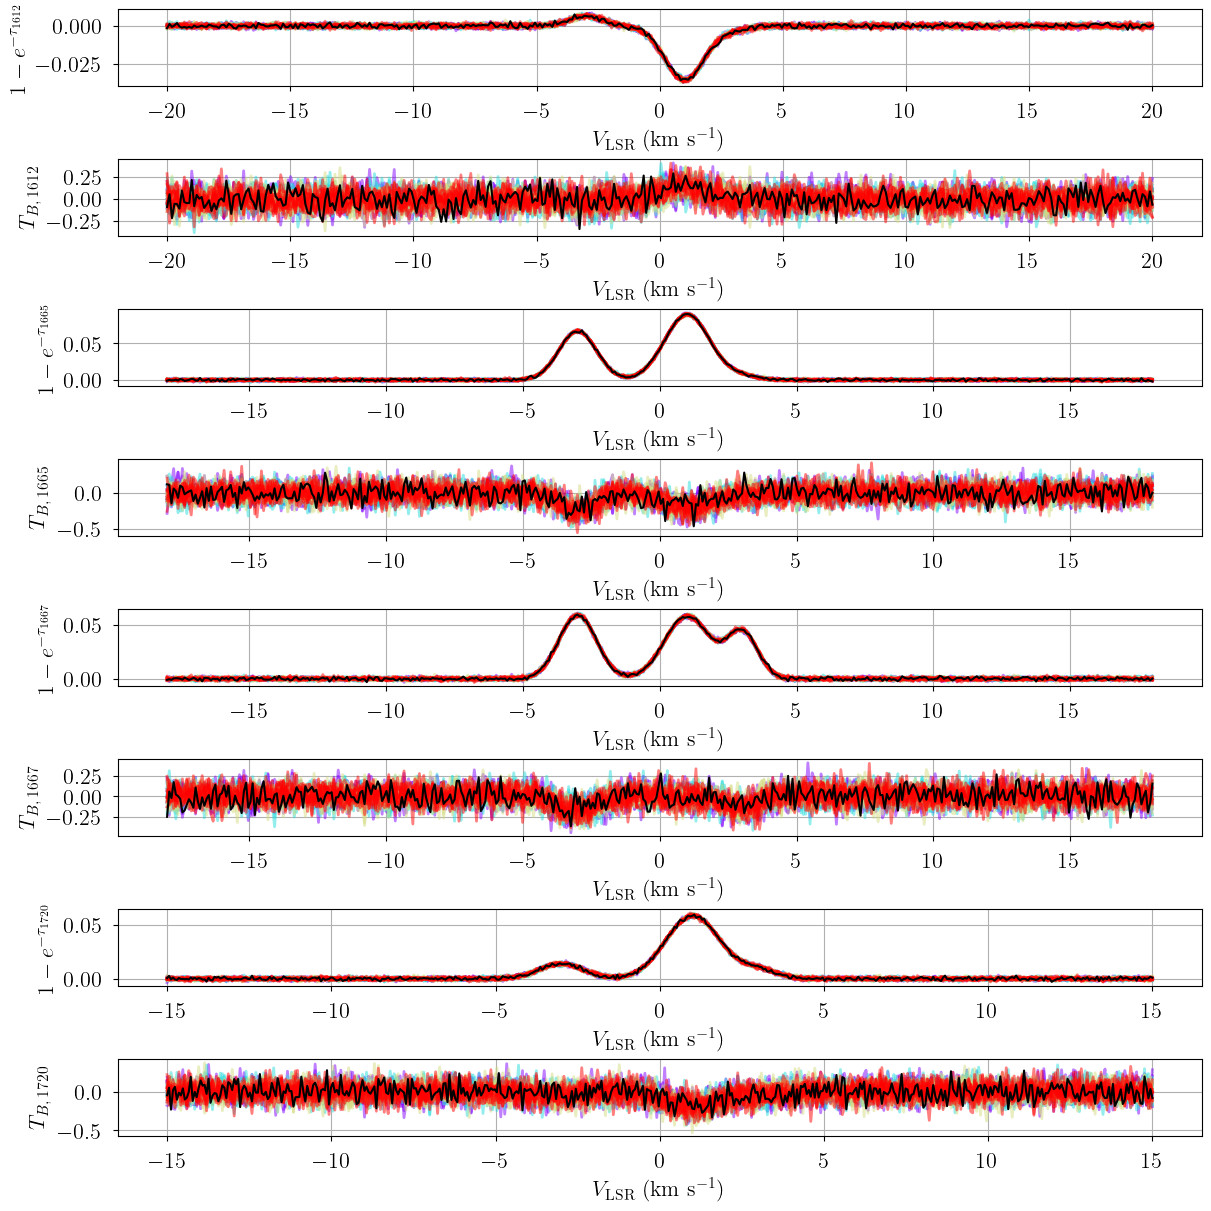

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

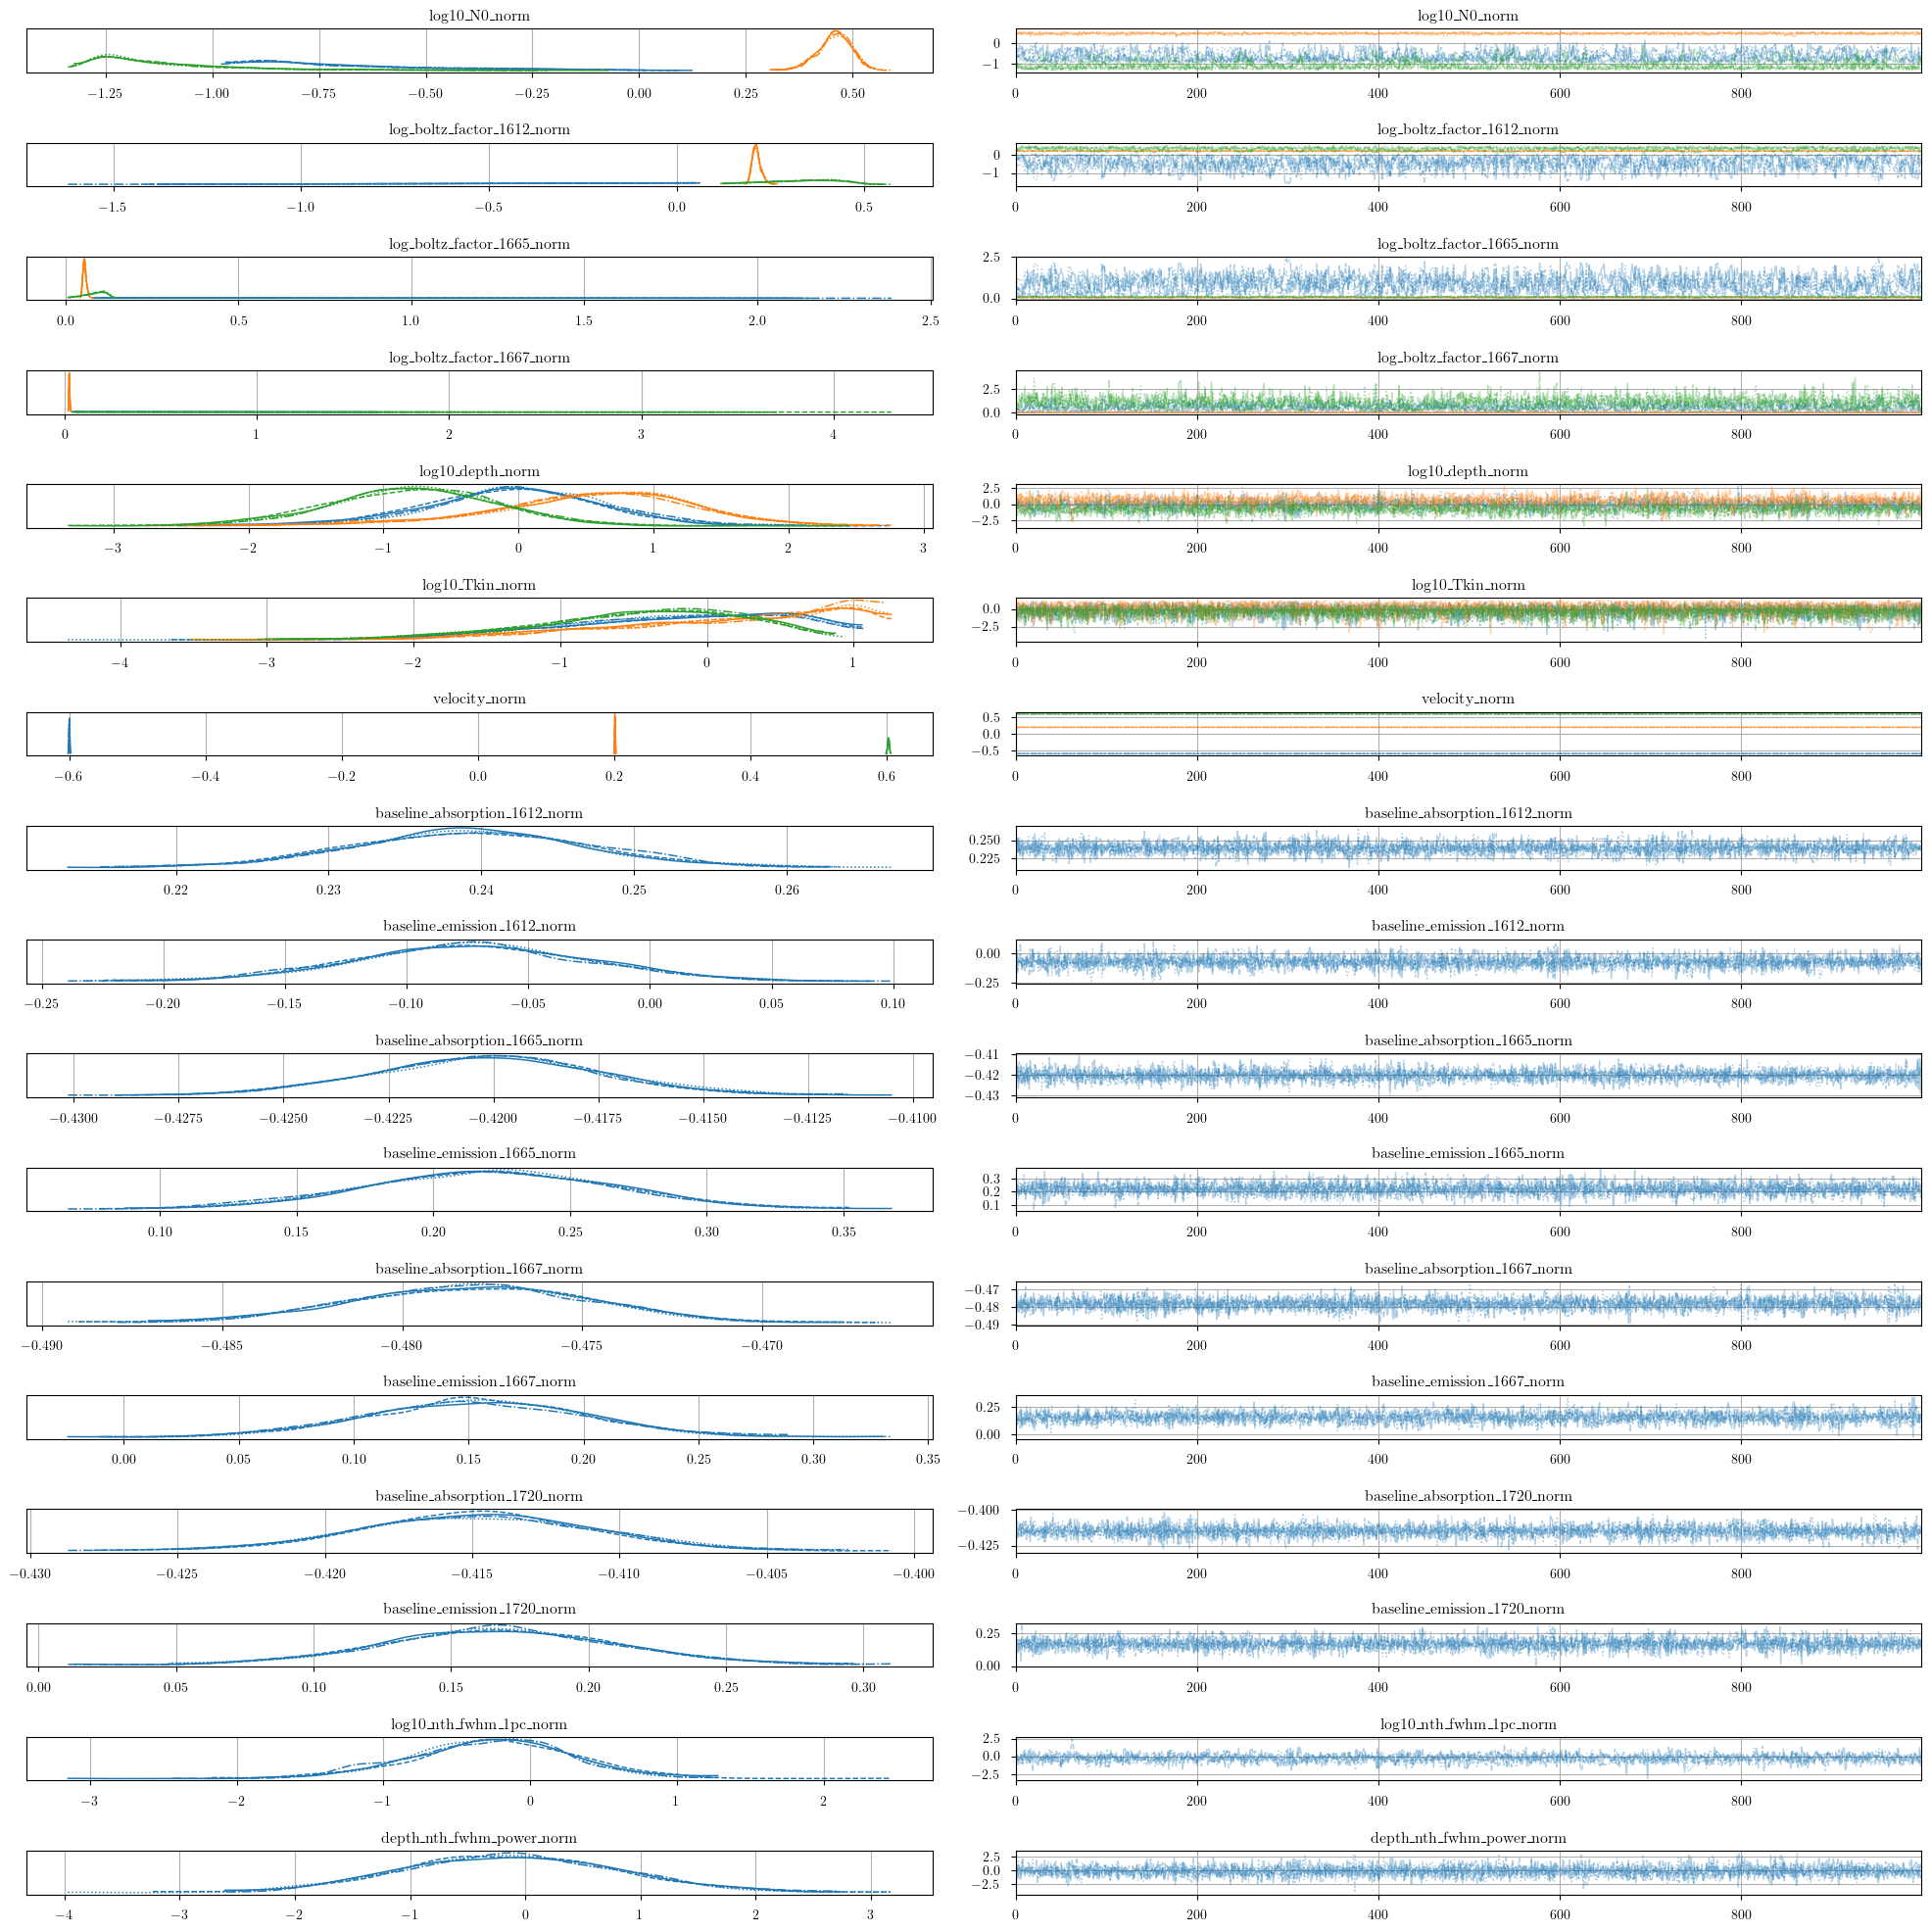

In [19]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(20, 20)
axes.ravel()[0].figure.tight_layout()

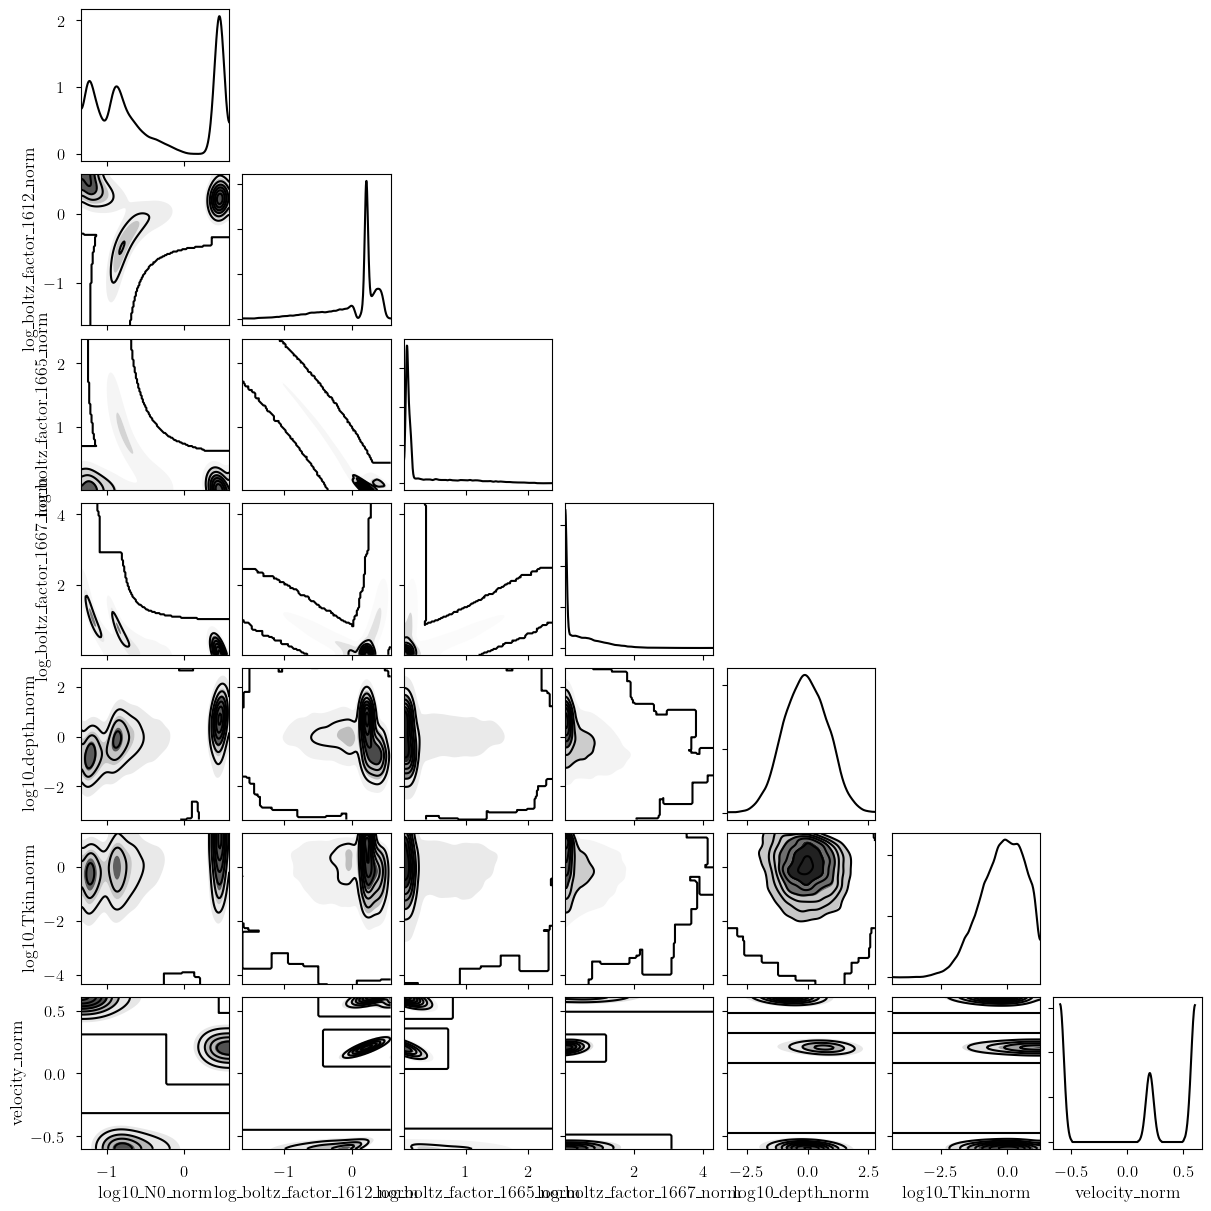

In [20]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

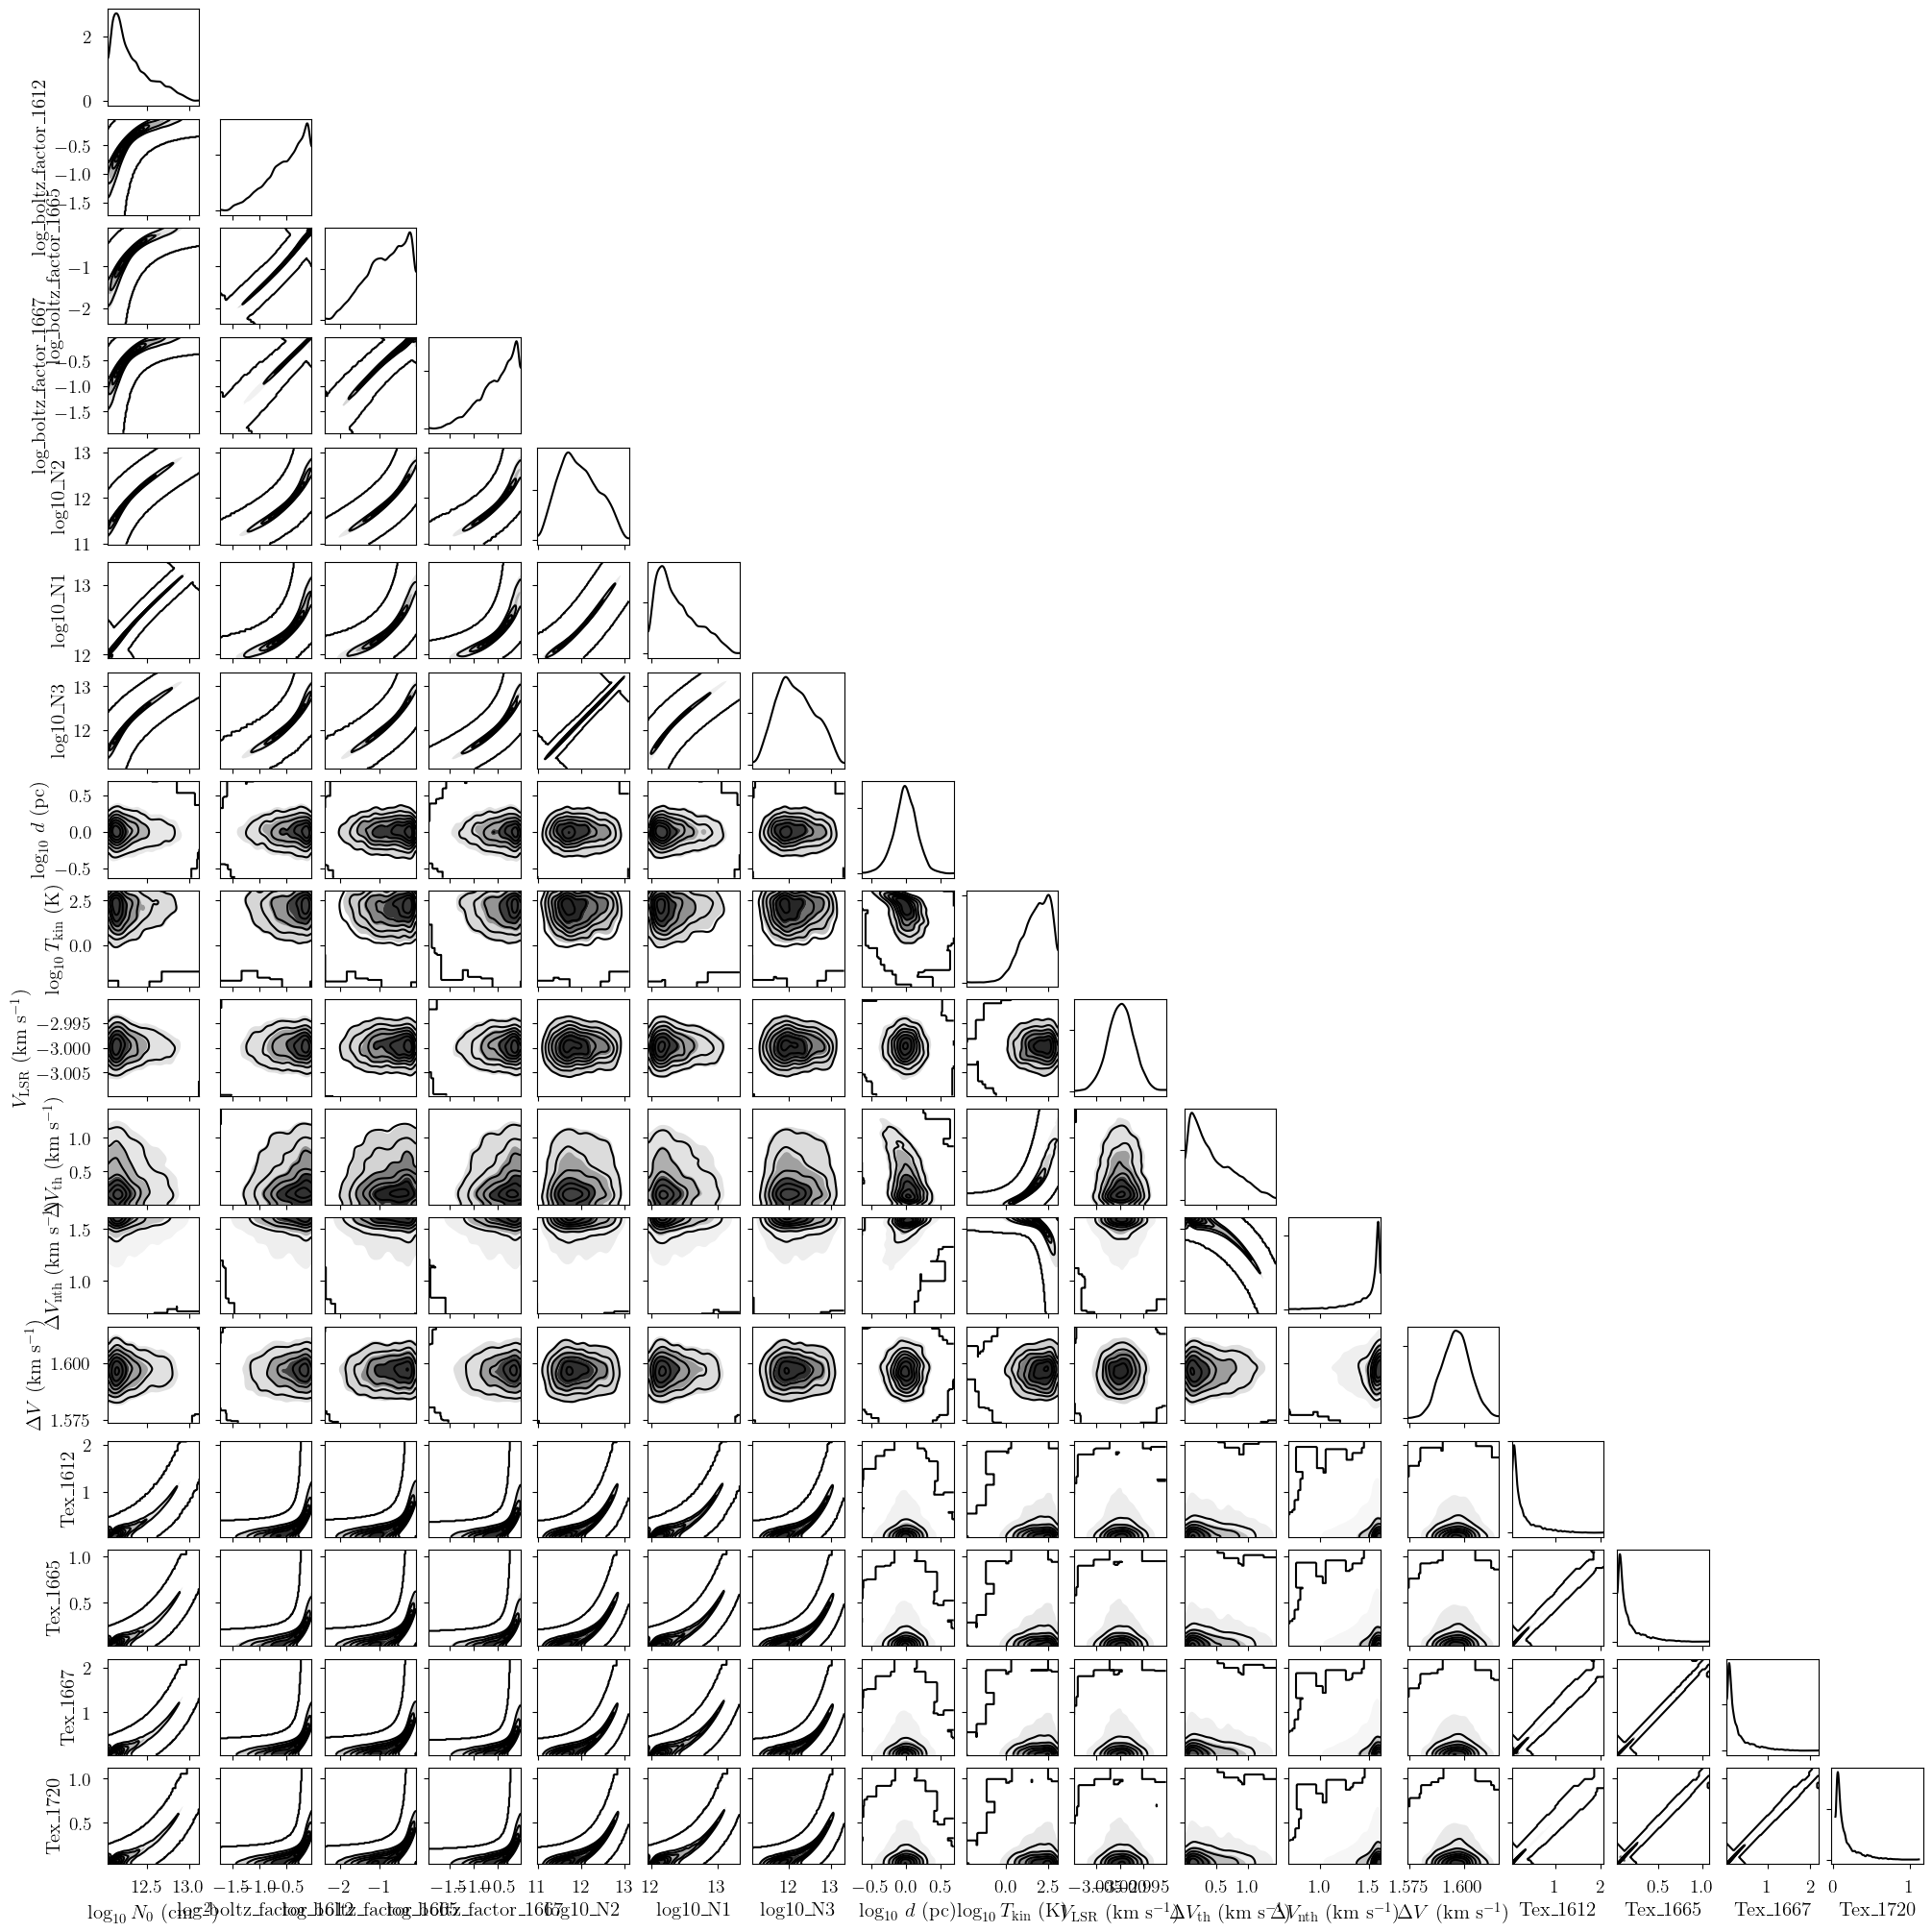

In [21]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

In [22]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
point_stats

BIC: -22711.57844783173


mean     sd  hdi_16%  hdi_84%
baseline_absorption_1612_norm[0]   0.239  0.008    0.232    0.247
baseline_emission_1612_norm[0]    -0.073  0.049   -0.123   -0.028
baseline_absorption_1665_norm[0]  -0.420  0.003   -0.423   -0.418
baseline_emission_1665_norm[0]     0.220  0.044    0.177    0.265
baseline_absorption_1667_norm[0]  -0.478  0.003   -0.481   -0.475
baseline_emission_1667_norm[0]     0.154  0.047    0.109    0.201
baseline_absorption_1720_norm[0]  -0.415  0.004   -0.419   -0.411
baseline_emission_1720_norm[0]     0.168  0.042    0.124    0.207
log10_N0_norm[0]                  -0.685  0.229   -0.966   -0.621
log10_N0_norm[1]                   0.458  0.039    0.431    0.506
log10_N0_norm[2]                  -1.105  0.195   -1.303   -1.068
log_boltz_factor_1612_norm[0]     -0.413  0.352   -0.560    0.045
log_boltz_factor_1612_norm[1]      0.213  0.012    0.199    0.220
log_boltz_factor_1612_norm[2]      0.337  0.092    0.277    0.467
log10_depth_norm[0]               -0.025  0.663   -0.584    0.652
log10_depth_norm[1]                0.541  0.767   -0.012    1.368
log10_depth_norm[2]               -0.784  0.632   -1.390   -0.184
log10_Tkin_norm[0]                -0.233  0.790   -0.728    0.802
log10_Tkin_norm[1]                 0.118  0.855   -0.214    1.212
log10_Tkin_norm[2]                -0.463  0.716   -0.958    0.405
velocity_norm[0]                  -0.600  0.001   -0.601   -0.599
velocity_norm[1]                   0.201  0.001    0.200    0.201
velocity_norm[2]                   0.603  0.001    0.601    0.604
log10_nth_fwhm_1pc_norm           -0.266  0.550   -0.716    0.326
depth_nth_fwhm_power_norm         -0.120  0.929   -1.027    0.811
log_boltz_factor_1665_norm[0]      0.843  0.504    0.122    1.095
log_boltz_factor_1665_norm[1]      0.056  0.005    0.050    0.059
log_boltz_factor_1665_norm[2]      0.087  0.030    0.068    0.126
log_boltz_factor_1667_norm[0]      0.533  0.370    0.060    0.684
log_boltz_factor_1667_norm[1]      0.023  0.003    0.020    0.024
log_boltz_factor_1667_norm[2]      0.965  0.620    0.097    1.225
log10_N0[0]                       12.315  0.229   12.034   12.379
log10_N0[1]                       13.458  0.039   13.431   13.506
log10_N0[2]                       11.895  0.195   11.697   11.932
log_boltz_factor_1612[0]          -0.513  0.352   -0.660   -0.055
log_boltz_factor_1612[1]           0.113  0.012    0.099    0.120
log_boltz_factor_1612[2]           0.237  0.092    0.177    0.367
log_boltz_factor_1665[0]          -0.843  0.504   -1.095   -0.122
log_boltz_factor_1665[1]          -0.056  0.005   -0.059   -0.050
log_boltz_factor_1665[2]          -0.087  0.030   -0.126   -0.068
log_boltz_factor_1667[0]          -0.533  0.370   -0.684   -0.060
log_boltz_factor_1667[1]          -0.023  0.003   -0.024   -0.020
log_boltz_factor_1667[2]          -0.965  0.620   -1.225   -0.097
log_boltz_factor_1720[0]          -0.862  0.523   -1.124   -0.130
log_boltz_factor_1720[1]          -0.192  0.020   -0.204   -0.168
log_boltz_factor_1720[2]          -1.289  0.732   -1.776   -0.335
log10_N2[0]                       11.949  0.436   11.391   12.314
log10_N2[1]                       13.433  0.042   13.406   13.485
log10_N2[2]                       11.857  0.207   11.638   11.898
log10_N1[0]                       12.394  0.294   12.000   12.511
log10_N1[1]                       13.606  0.047   13.575   13.664
log10_N1[2]                       11.976  0.244   11.706   12.043
log10_N3[0]                       12.162  0.443   11.600   12.539
log10_N3[1]                       13.596  0.048   13.564   13.655
log10_N3[2]                       11.557  0.490   10.986   11.957
log10_depth[0]                    -0.006  0.166   -0.146    0.163
log10_depth[1]                     0.135  0.192   -0.003    0.342
log10_depth[2]                    -0.196  0.158   -0.347   -0.046
log10_Tkin[0]                      1.767  0.790    1.272    2.802
log10_Tkin[1]                      2.118  0.855    1.786    3.212
log10_Tkin